* Student name: Steve Newman
* Student pace: part time 
* Scheduled project review date/time: Tues. May 12 12:30 pm EST
* Instructor name: James Irving PhD
* Blog post URL:https://medium.com/@stevenewmanphotography/classification-blog-e73e72cb8450

# Mod 3 Project Overview

The objective of this project is to leverage classification modelling concepts into an applied real-life scenario in which I have selected my own data set. My data set comes from Kaggle and is titled Sales Conversion Optimization (https://www.kaggle.com/loveall/clicks-conversion-tracking). The target in this data set is labeled Approved Conversion and has values ranging from 0 to 6. For the purposes of model simplification, Approved Conversion was transposed to the binary values of 0 and 1, representing purchased or not.

# Defintions

The data used in this project is from an anonymous organisation’s social media ad campaign.  The file conversion_data.csv contains 1143 observations in 11 variables. Below are the descriptions of the variables.

1.) ad_id: an unique ID for each ad.

2.) xyzcampaignid: an ID associated with each ad campaign of XYZ company.

3.) fbcampaignid: an ID associated with how Facebook tracks each campaign.

4.) age: age of the person to whom the ad is shown.

5.) gender: gender of the person to whim the add is shown

6.) interest: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

7.) Impressions: the number of times the ad was shown.

8.) Clicks: number of clicks on for that ad.

9.) Spent: Amount paid by company xyz to Facebook, to show that ad.

10.) Total conversion: Total number of people who enquired about the product after seeing the ad.

11.) Approved conversion: Total number of people who bought the product after seeing the ad.

In [1]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
import tzlocal
import datetime as dt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier,XGBClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


fsds_1007219  v0.7.21 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


# Explored Data Set

In [2]:
df = pd.read_csv('KAG_conversion_data.csv')
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710000,8,2


In [3]:
# No missing values.

df.isna().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

In [4]:
# Will need to convert some columns to categories.

df.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [5]:
# ad_id needs to be dropped due to number of unique values.

df.nunique()

ad_id                  1143
xyz_campaign_id           3
fb_campaign_id          691
age                       4
gender                    2
interest                 40
Impressions            1130
Clicks                  183
Spent                   869
Total_Conversion         32
Approved_Conversion      16
dtype: int64

# Prepare Data for Modeling

In [6]:
#Drop ad_id due to, too many unique values.

df= df.drop(columns=['ad_id'])

In [7]:
# Check if 'Approved_Conversion' correlates with the target.
df= df.drop(columns=['Total_Conversion'])
df.corr().loc['Approved_Conversion']

xyz_campaign_id        0.284968
fb_campaign_id         0.257658
interest               0.058353
Impressions            0.684249
Clicks                 0.559526
Spent                  0.593178
Approved_Conversion    1.000000
Name: Approved_Conversion, dtype: float64

In [8]:
# Convert 'fb_campaign_id' to value count number due to approximately 700 unique values.

campaign_id = dict(df['fb_campaign_id'].value_counts())
df['fb_counts'] = df['fb_campaign_id'].map(campaign_id)
df['fb_counts'].value_counts(dropna=False)

1    463
2    218
3    153
4    148
5    125
6     36
Name: fb_counts, dtype: int64

In [9]:
# Encoding age groups as ordinal

age_ranges = ('30-34','35-39', '40-44','45-49')
age_codes = (0,1,2,3) 
# Zipping into Dictionary to Map onto Column

age_map = dict(zip(age_ranges,age_codes))
age_map

{'30-34': 0, '35-39': 1, '40-44': 2, '45-49': 3}

In [10]:
# Applying age_map to 'age_number' column.

df['age_number'] = df['age'].map(age_map)
df['age_number'].value_counts(dropna=False)

0    426
3    259
1    248
2    210
Name: age_number, dtype: int64

In [11]:
df

,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Approved_Conversion,fb_counts,age_number
0,916,103916,30-34,M,15,7350,1,1.430000,1,1,0
1,916,103917,30-34,M,16,17861,2,1.820000,0,1,0
2,916,103920,30-34,M,20,693,0,0.000000,0,1,0
3,916,103928,30-34,M,28,4259,1,1.250000,0,2,0
4,916,103928,30-34,M,28,4133,1,1.290000,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1138,1178,179977,45-49,F,109,1129773,252,358.189997,2,1,3
1139,1178,179978,45-49,F,110,637549,120,173.880003,0,1,3
1140,1178,179979,45-49,F,111,151531,28,40.289999,0,1,3
1141,1178,179981,45-49,F,113,790253,135,198.710000,2,1,3


In [12]:
# Convert 'Approved_Conversion' from 1 to 6 values to 1 or 0.

df['Approved_Conversion'] = df['Approved_Conversion'].astype('bool').astype('int')

In [13]:
df['Approved_Conversion']

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [14]:
# Convert 'xyz_campaign_id' and 'interest' to category.

to_category = ['xyz_campaign_id','interest']
df[to_category] = df[to_category].astype('category')

In [15]:
df.dtypes

xyz_campaign_id        category
fb_campaign_id            int64
age                      object
gender                   object
interest               category
Impressions               int64
Clicks                    int64
Spent                   float64
Approved_Conversion       int64
fb_counts                 int64
age_number                int64
dtype: object

In [16]:
# Drop 'fb_campaign_id' and 'age' due to them being transformed into new columns.

df= df.drop(columns=['fb_campaign_id','age'])

In [17]:
df

,xyz_campaign_id,gender,interest,Impressions,Clicks,Spent,Approved_Conversion,fb_counts,age_number
0,916,M,15,7350,1,1.430000,1,1,0
1,916,M,16,17861,2,1.820000,0,1,0
2,916,M,20,693,0,0.000000,0,1,0
3,916,M,28,4259,1,1.250000,0,2,0
4,916,M,28,4133,1,1.290000,1,2,0
...,...,...,...,...,...,...,...,...,...
1138,1178,F,109,1129773,252,358.189997,1,1,3
1139,1178,F,110,637549,120,173.880003,0,1,3
1140,1178,F,111,151531,28,40.289999,0,1,3
1141,1178,F,113,790253,135,198.710000,1,1,3


In [18]:
# One hot encode categorical data.

df = pd.get_dummies(df)
df.head()

,Impressions,Clicks,Spent,Approved_Conversion,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,gender_F,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
0,7350,1,1.43,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17861,2,1.82,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,693,0,0.00,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4259,1,1.25,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4133,1,1.29,1,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Isolate the target.

y = df.pop('Approved_Conversion')

In [20]:
y

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [21]:
# Train test split

X_train, X_test, y_train,y_test  = train_test_split(df,y,test_size=.3, random_state=123)

In [22]:
X_train

,Impressions,Clicks,Spent,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,gender_F,gender_M,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
957,46391,11,16.410000,3,2,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1097,780967,86,119.640002,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
805,111963,17,29.379999,6,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
298,11735,3,4.530000,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
646,64647,10,16.270000,5,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2522,0,0.000000,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
96,1357,0,0.000000,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
106,69708,20,31.289999,1,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1041,1111156,282,402.300003,3,3,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Check for imbalance.

y_train.value_counts(normalize=True)

1    0.515
0    0.485
Name: Approved_Conversion, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

1    0.501458
0    0.498542
Name: Approved_Conversion, dtype: float64

# Run Model Function

In [25]:
def run_model(clf, X_trn, y_trn, X_true):
    
    '''
    Intitializes Timer class, starts Timer, fits model, stops Timer, and returns y_hat_test 
    (predicted values of X_true) and clf (classifier).
    
        Parameters:
            
            clf: classifier or instanciated model
            X_trn: X train from test, train, split
            y_trn: y train from test, train, split
            X_true: X test from test, train, split
            
        Returns:
            
            y_hat_test and clf
            
    '''

    
    timer = Timer()
    timer.start()

    clf.fit(X_trn,y_trn)
    
    y_hat_test = clf.predict(X_true)
    
    timer.stop()
    return y_hat_test, clf

# Model Evaluation Function

In [26]:
def evaluate_model(clf, y_trn, y_true, y_pred, X_trn, X_true):
    
    '''
    Calculates and displays the following: Train and Test Score, Classification Report, 
    Confusion Matrix, ROC Curve, and Importance Series.
    
        Parameters:
            
            clf: classifier or instanciated model from run_model function
            y_trn: y train from test, train, split
            y_true: y test from test, train, split
            y_pred: y hat test from run_model fuction
            X_trn: X train from test, train, split
            X_true: X test from test, train, split
    
    '''
    # Calculates and displays train and test scores.
    train_score = clf.score(X_trn,y_trn)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}")
    
    # Displays Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    # Displays Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,4),ncols=2)
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax[0])
    ax[0].set(title='Confusion Matrix')
    ax[0].grid(False)
    y_score = clf.predict_proba(X_true)[:,1]
    
    # Calculates and displays ROC Curve
    fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
    roc_auc = round(metrics.auc(fpr,tpr),3)
    ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].legend()
    ax[1].grid()
    ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',title='Receiver operating characteristic (ROC) Curve')
    plt.tight_layout()
    plt.show()

    # Calculates and displays Feature Importances.
    df_import = pd.Series(clf.feature_importances_, index = X_train.columns,name='Importance')
    print(df_import.sort_values(ascending=False).head())

# Timer Class/Function

In [27]:
class Timer():
    '''
    Timer class with __init__, get_time, start, and stop function defined within. 
    
    '''
    
    # Initialize Timer class, define format, establish local timezone.
    def __init__(self,format_="%m/%d/%y - %I:%M %p"):
        import tzlocal
        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        
        self.created_at = self.get_time()# get time
        
    # Define get time method
    def get_time(self):
        '''
        Returns current time in local timezone.
        
        '''
        import datetime as dt
        return dt.datetime.now(self.tz)

    # Define start
    def start(self):
        '''
        Runs get_time and displays start time.
        
        '''
        time = self.get_time()
        self.start = time
        print(f"[i] Timer started at{self.start.strftime(self.fmt)}")
        
    # Define stop
    def stop(self):
        '''
        Runs get_time and stores as self.end. Displays end and elapsed time.
        
        '''
        time = self.get_time()
        self.end = time
        print(f"[i] Timer ended at {self.end.strftime(self.fmt)}")
        print(f"- Total time = {self.end-self.start}")

# Test Timer class
timer = Timer()
print(timer.created_at)
timer.start()
timer.stop()

2020-05-12 13:02:35.849998-04:00
[i] Timer started at05/12/20 - 01:02 PM
[i] Timer ended at 05/12/20 - 01:02 PM
- Total time = 0:00:00.000108


# Tree Visualization Function

In [28]:
# Visualize the decision tree
def visualize_tree(tree,feature_names=None,class_names=['0','1'],
                   kws={},save_filename=None,format_='png',save_and_show=False):
    """
    Visualizes a sklearn tree using sklearn.tree.export_graphviz.
    
        Parameters:
            tree: Classifier
            feature_names: (default is None) X Train columns
            class_names: default is a list 0 and 1
            kws: empty dictionary
            save_filename: (default is None) file name
            format: default 'png'
            save_and_show: default False
            
    Returns display of visualization of tree and saved file.
    
    """
    # Import needed packages
    from sklearn.tree import export_graphviz
    from IPython.display import SVG
    import graphviz #import Source
    from IPython.display import display
    
    # Set feature names values
    if feature_names is None:
        feature_names=X_train.columns

    # tree_viz_kws dictionary    
    tree_viz_kws =  dict(out_file=None,rounded=True, rotate=False, filled = True)
    tree_viz_kws.update(kws)

    # tree.export_graphviz(dt) #if you wish to save the output to a dot file instead
    tree_data=export_graphviz(tree,feature_names=feature_names, 
                                   class_names=class_names,**tree_viz_kws)
    graph = graphviz.Source(tree_data,format=format_)
    
    # Save file name
    if save_filename is not None:
        graph.render(save_filename)
        if save_and_show:
            display(graph)
        else:
            print(f'[i] Tree saved as {save_filename}.{format_}')
    else:
        display(graph)

# Decision Tree Model

In [29]:
tree = DecisionTreeClassifier(max_depth=5)

In [30]:
y_hat_test, clf = run_model(tree, X_train, y_train, X_test)

[i] Timer started at05/12/20 - 01:02 PM
[i] Timer ended at 05/12/20 - 01:02 PM
- Total time = 0:00:00.013241


# Decision Tree Results

Train score= 0.705
Test score= 0.5568513119533528
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       171
           1       0.56      0.55      0.56       172

    accuracy                           0.56       343
   macro avg       0.56      0.56      0.56       343
weighted avg       0.56      0.56      0.56       343



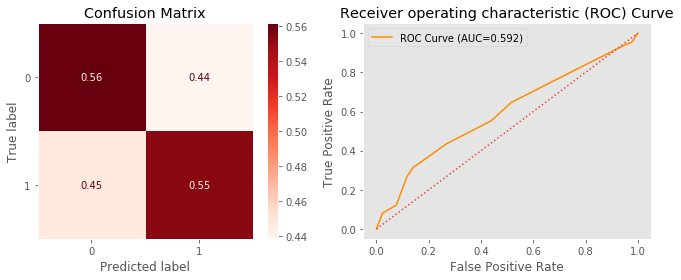

Impressions    0.651394
Spent          0.174677
interest_65    0.051234
interest_22    0.044315
interest_10    0.017917
Name: Importance, dtype: float64


In [31]:
evaluate_model(clf, y_train, y_test, y_hat_test, X_train, X_test)

## First Decision Tree model shows mediocre results. The model scored 73% on the training data and 60% on the testing data. While the scores indicate that the model did slightly overfit, it only performed slightly better than 60% on recall. It did a descent job predicting true negative (69%) however it fell short in predicting true positive (54%). The most influenctial predictor by far is Impressions.

# Visualize Tree

In [32]:
visualize_tree(tree,feature_names=X_train.columns,save_filename='Tree')

[i] Tree saved as Tree.png


# Random Forest Model

In [33]:
rf = RandomForestClassifier()

In [34]:
y_hat_test, clf = run_model(rf, X_train, y_train, X_test)

[i] Timer started at05/12/20 - 01:02 PM
[i] Timer ended at 05/12/20 - 01:02 PM
- Total time = 0:00:00.910488


# Random Forest Results

Train score= 1.0
Test score= 0.5539358600583091
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       171
           1       0.56      0.51      0.53       172

    accuracy                           0.55       343
   macro avg       0.55      0.55      0.55       343
weighted avg       0.55      0.55      0.55       343



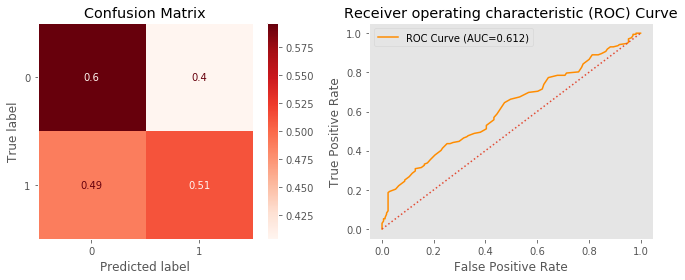

Impressions    0.227816
Spent          0.166355
Clicks         0.138236
fb_counts      0.059875
age_number     0.059389
Name: Importance, dtype: float64


In [35]:
evaluate_model(clf, y_train, y_test,y_hat_test,X_train, X_test)

## Random Forest overtrained the test data, indicated by a Train Score of 1. The results were surprisingly similar to a plain Decision Tree with exception of the overtrained train data. Clicks did make a showing in the top three pedictors, where it had not in the past.

# RF Grid Search

In [36]:
tree = RandomForestClassifier()

# Set up param grid

param_grid = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'max_features':[None,'auto','sqrt',3,5,10,30,70],
              'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(tree,param_grid)

In [37]:
timer = Timer()
timer.start()

grid_clf.fit(X_train, y_train)

timer.stop()

grid_clf.best_params_

[i] Timer started at05/12/20 - 01:02 PM
[i] Timer ended at 05/12/20 - 01:07 PM
- Total time = 0:04:30.208613


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2}

In [38]:
# Create a tree with the gridsearch's best params

best_tree = RandomForestClassifier(**grid_clf.best_params_)

In [39]:
# Create a tree with the gridsearch's best params

timer = Timer()
timer.start()

best_tree.fit(X_train,y_train)

timer.stop()

[i] Timer started at05/12/20 - 01:07 PM
[i] Timer ended at 05/12/20 - 01:07 PM
- Total time = 0:00:00.156326


# RF Grid Search Results

Train score= 0.6875
Test score= 0.6151603498542274
              precision    recall  f1-score   support

           0       0.60      0.70      0.65       171
           1       0.64      0.53      0.58       172

    accuracy                           0.62       343
   macro avg       0.62      0.62      0.61       343
weighted avg       0.62      0.62      0.61       343



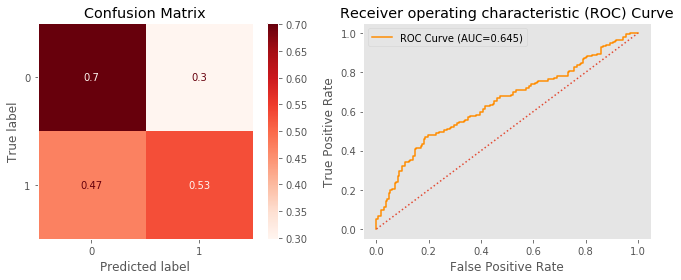

Impressions             0.250469
Clicks                  0.198064
Spent                   0.176437
xyz_campaign_id_936     0.051255
xyz_campaign_id_1178    0.047348
Name: Importance, dtype: float64


In [40]:
y_hat_test = best_tree.predict(X_test)

evaluate_model(best_tree, y_train, y_test, y_hat_test,X_train, X_test)

## Similiar results to D. Tree Grid Search; slight over train of training data. .58 recall.

# XGBOOST Model

In [41]:
xgb_rf = XGBRFClassifier()

In [42]:
y_hat_test, clf = run_model(xgb_rf, X_train, y_train, X_test)

[i] Timer started at05/12/20 - 01:07 PM
[i] Timer ended at 05/12/20 - 01:07 PM
- Total time = 0:00:00.121370


# XGBOOST Results

Train score= 0.685
Test score= 0.597667638483965
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       171
           1       0.61      0.53      0.57       172

    accuracy                           0.60       343
   macro avg       0.60      0.60      0.60       343
weighted avg       0.60      0.60      0.60       343



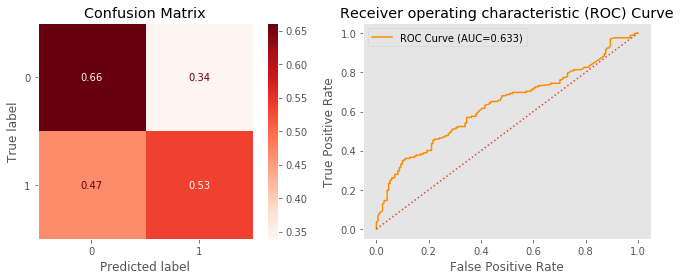

xyz_campaign_id_1178    0.217722
Impressions             0.166799
xyz_campaign_id_936     0.098505
Spent                   0.090730
gender_M                0.048028
Name: Importance, dtype: float32


In [43]:
evaluate_model(clf,y_train, y_test,y_hat_test,X_train, X_test)

## Average results; very low true positive results.

# XGBOOST RF Model

In [44]:
xgbrf_grid = {'colsample_bynode': 0.8, 'learning_rate': .1,
              'max_depth': 5, 'num_parallel_tree': 100, 
              'objective': 'binary:logistic', 'subsample': 0.8}

xrf_clf = XGBRFClassifier(**xgbrf_grid)

In [45]:
timer = Timer()
timer.start()

xrf_clf = XGBRFClassifier(**xgbrf_grid)
xrf_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/12/20 - 01:07 PM
[i] Timer ended at 05/12/20 - 01:07 PM
- Total time = 0:00:00.192964


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2}

# XGBOOST RF Results

Train score= 0.71125
Test score= 0.6064139941690962
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       171
           1       0.63      0.52      0.57       172

    accuracy                           0.61       343
   macro avg       0.61      0.61      0.60       343
weighted avg       0.61      0.61      0.60       343



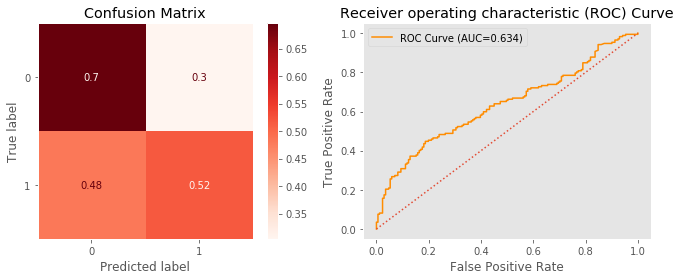

Impressions             0.120460
xyz_campaign_id_1178    0.091145
Spent                   0.068425
interest_65             0.061968
xyz_campaign_id_936     0.055110
Name: Importance, dtype: float32


In [46]:
y_hat_test = xrf_clf.predict(X_test)

evaluate_model(xrf_clf, y_train, y_test,y_hat_test,X_train, X_test)

## Overtrained training set and very low true positive results.

# Grid Search CV Model

In [530]:
tree = DecisionTreeClassifier()


param_grid = {'criterion':['entropy'],
             'max_depth':[3,4,5],
             'max_features':[None,'sqrt'],
              'min_samples_leaf': [1,2,3]
             'random_state': [123]}
default_tree = DecisionTreeClassifier(**param_grid)
grid_clf = GridSearchCV(tree,param_grid)

In [531]:
timer = Timer()
timer.start()

# Fit Grid Search to Decission Tree.

grid_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/12/20 - 11:21 AM
[i] Timer ended at 05/12/20 - 11:21 AM
- Total time = 0:00:00.044177


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 3}

In [532]:
# Create a tree with the gridsearch's best params

best_tree = DecisionTreeClassifier(**grid_clf.best_params_)
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Grid Search CV Results

Train score= 0.62375
Test score= 0.597667638483965
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       171
           1       0.59      0.67      0.63       172

    accuracy                           0.60       343
   macro avg       0.60      0.60      0.60       343
weighted avg       0.60      0.60      0.60       343



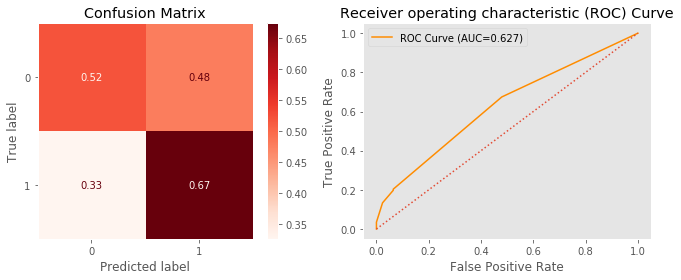

Spent                  0.802933
xyz_campaign_id_936    0.164539
Clicks                 0.018951
interest_113           0.013577
interest_114           0.000000
Name: Importance, dtype: float64


In [533]:
y_hat_test = best_tree.predict(X_test)

evaluate_model(best_tree, y_train, y_test,y_hat_test,X_train, X_test)

# Final Results

# For the business problem of identifying which variables contribute to classifying if customers make a purchase; Grid Search CV on a Decision Tree model had the best results of all the models tried. Specifically the variables criterion: entropy; max_depth: 3; max_features: sqrt; min_samples_leaf: 3.


# The training and test score are both mid to low .60's indicating that the model did not over or under fit the training data and had a siliar result on the test data. 

# The recall score of .67 indicates a 17% improvement of identifying true positives from random chance. The top three predictors are Impressions,  xyz_campaign_id_936, and interest_110.

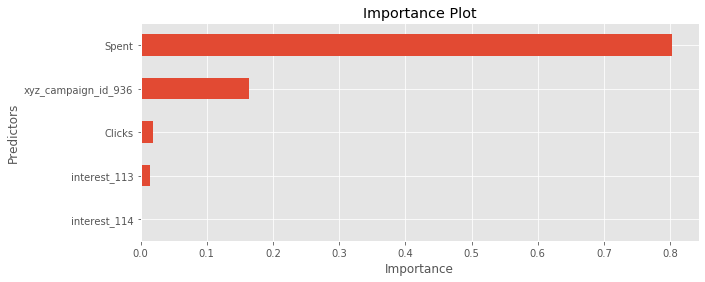

In [534]:
fig, ax = plt.subplots(figsize=(10,4))
df_import = pd.Series(best_tree.feature_importances_, index = X_train.columns,name='Importance')
(df_import.sort_values(ascending=True).tail()).plot(kind = 'barh')
xaxis = 'Importance'
ax.set(ylabel='Predictors',xlabel='Importance',title='Importance Plot');

# Recommendations

I recommend to invest a large amount into ads for the best return on investment. Specifically replicate what is done in ad id number 936. For an extra boost, focus on interest number 113.

# Future Work

In the future, I would try to work with a larger data set including both rows of customer behavior and columns of predictors. Additionally, I would like to look at trends across seasonal time periods. Perhaps different marketing strategies will be more affective in different time periods. Lastly, I would research into what exactly the interest codes translate to.